# Initialization

In [1]:
# %load init.ipy
# NOTE: This is for when the notebook is converted to a python script
# NOTE: this MUST precede the magic functions
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))
    
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime, warnings, shutil
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
from kalepy.plot import plot_control

def _save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot._save_fig(fig, fname, **kwargs)
    
save_fig = _save_fig

In [2]:
def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('subdir', 'plotting')
    return _save_fig(fig, fname, **kwargs)

# Generate Random Data

In [3]:
NUM = 3000
# bandwidth = 0.2

labels = 'ABC'
sigma = [1.0, 0.2, 1.5]
corr = [
    [+1.0, +0.8, +0.4],
    [+0.8, +1.0, -0.5],
    [+0.2, -0.5, +1.0]
]

s2 = np.square(sigma)

cov = np.zeros_like(corr)
for (ii, jj), cc in np.ndenumerate(corr):
    cov[ii, jj] = cc * sigma[ii] * sigma[jj]

data = np.random.multivariate_normal(np.zeros_like(sigma), cov, NUM).T
dd = data[1, :]
dd = (dd - dd.min())/dd.max()
data *= np.sqrt(dd)[np.newaxis, :]

pc = 0
extr = [np.percentile(dd, [0+pc, 100-pc]) for dd in data]
noise = [np.random.uniform(*ex, NUM//5) for ex in extr]
data = np.append(data, noise, axis=1)

/Users/lzkelley/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: covariance is not positive-semidefinite.


# Corner / Pair Plot

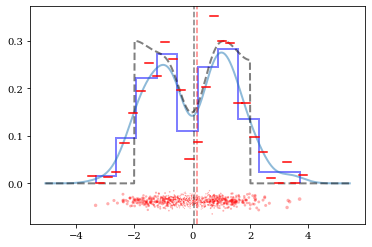

In [62]:
reload(kale.plot)
reload(kale.utils)
kw = dict(lw=2.0, alpha=0.5)

xx = np.random.normal(size=1000)
yy = np.fabs(xx)

ax = plt.gca()
ax.hist(xx, weights=yy, density=True, histtype='step', color='b', **kw)
# ax.hist(xx, density=True, histtype='step', color='b', ls='--', **kw)

kde = kale.KDE(xx, kernel=kernel, weights=yy)
edges = np.squeeze(kde._guess_edges())
ax.plot(edges, kde.pdf(edges), **kw)
kale.plot.dist1d_kde(ax, kde, ls='--', contour=False, **kw)
kale.plot.dist1d_data(ax, data=xx, weights=yy, contour=False, color='r')

plt.show()


(0.00e+00, 2.36e-03, 2.92e-02, 1.54e-01, 1.00e+00), for (0%, 16%, 50%, 84%, 100%)


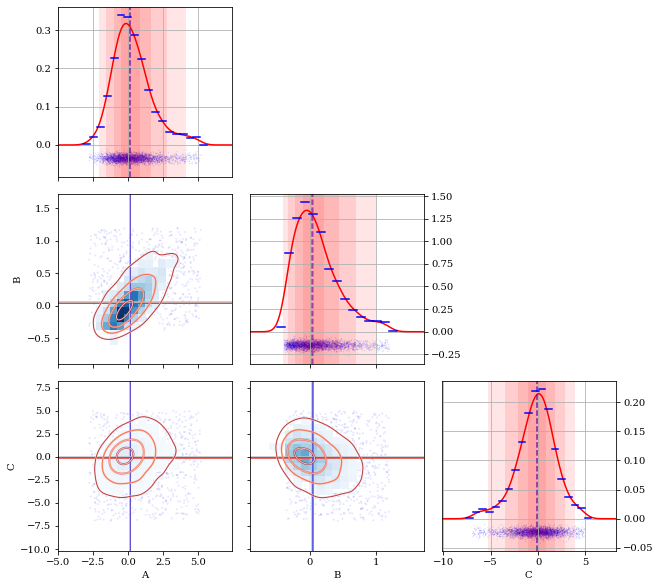

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner_08.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner_08.png'

In [20]:
reload(kalepy.plot)
reload(kalepy.utils)

# kernel = 'parabola'
kernel = 'gaussian'
weights = np.square(data[-1, :])
weights /= weights.max()
print(kale.utils.stats_str(weights))
weights = None
kde = kale.KDE(data, kernel=kernel, weights=weights)

corner = kale.plot.Corner(kde, figsize=[10, 10], labels=labels)

corner.plot(rotate=False, kde_kwargs=dict(color='r'), data_kwargs=dict(color='b'))

nbshow()
fname = 'corner.png'
save_fig(corner.fig, fname)

In [5]:
for ax in corner.axes[:, 0]:
    print(ax.get_xlim())
    
print()

for ax in corner.axes[-1, :]:
    print(ax.get_ylim())

(-3.2292193478435247, 5.634062992351832)
(-3.2292193478435247, 5.634062992351832)
(-3.2292193478435247, 5.634062992351832)

(-7.586034082602991, 5.615561870063463)
(-7.586034082602991, 5.615561870063463)
(-0.05116475543629386, 0.2407886458556681)


# Compare Data to KDE

## 1D Distributions

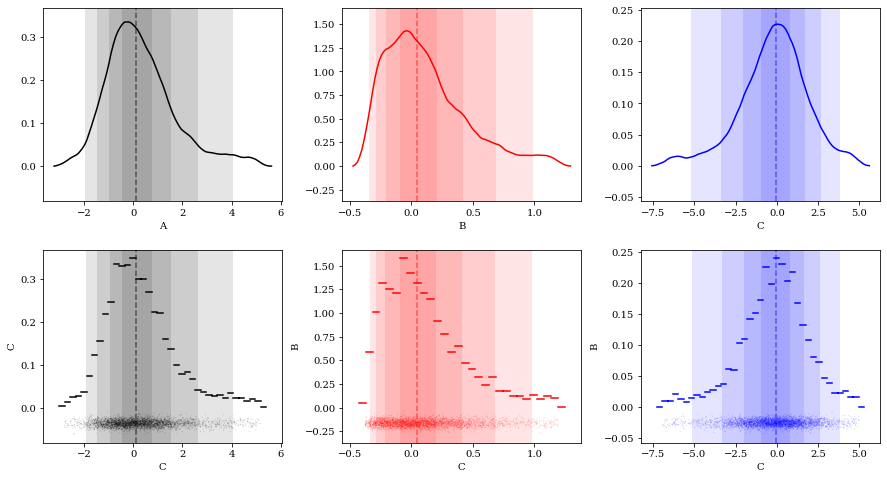

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/compare-1d_05.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/compare-1d_05.png'

In [6]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 8], ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

yextr = None
for kk, ax_col in enumerate(axes.T):
    color = colors[kk]
    
    ax = ax_col[0]
    ax.set(xlabel=labels[kk])
    kale.plot.dist1d_kde(ax, kde, param=kk, color=color)

    ax = ax_col[1]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    kale.plot.dist1d_data(ax, data=data[kk], color=color)
    

    extr = [None, None]
    for ax in ax_col:
        for ii, get_func in enumerate([ax.get_xlim, ax.get_ylim]):
            extr[ii] = kale.utils.minmax(get_func(), prev=extr[ii])
        
    for ax in ax_col:
        for ii, set_func in enumerate([ax.set_xlim, ax.set_ylim]):
            set_func(extr[ii])

nbshow()
fname = 'compare-1d.png'
save_fig(fig, fname)

## 2D Distributions

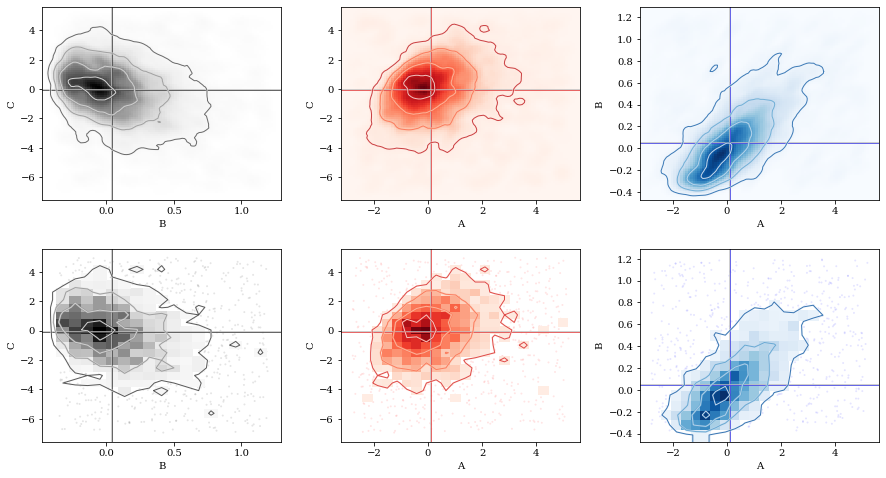

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/compare-2d_06.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/compare-2d_06.png'

In [7]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 8], ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.25, hspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

for kk, ax_col in enumerate(axes.T):
    color = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    jj, ii = np.sort([jj, ii])

    ax = ax_col[0]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    kale.plot.dist2d_kde(ax, kde, params=[jj, ii], color=color)

    ax = ax_col[1]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    kale.plot.dist2d_data(ax, data=[data[jj], data[ii]], color=color)
    
    extr = [None, None]
    for ax in ax_col:
        for ii, get_func in enumerate([ax.get_xlim, ax.get_ylim]):
            extr[ii] = kale.utils.minmax(get_func(), prev=extr[ii])

    for ax in ax_col:
        for ii, set_func in enumerate([ax.set_xlim, ax.set_ylim]):
            set_func(extr[ii])
            
nbshow()
fname = 'compare-2d.png'
save_fig(fig, fname)

# Data

## Full Corner Plot

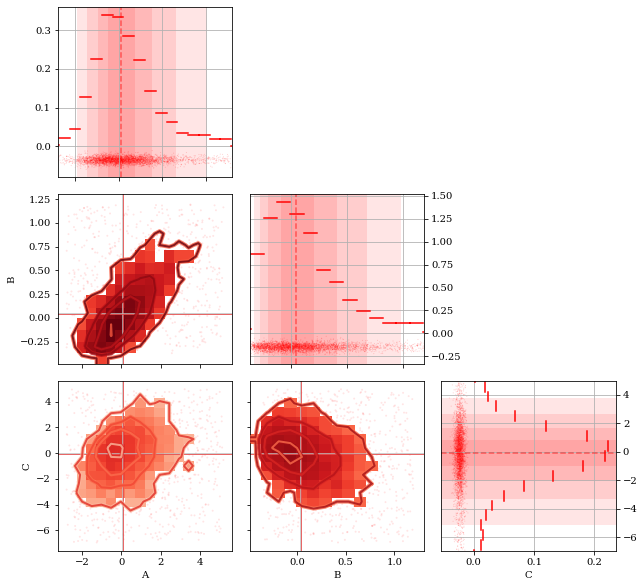

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-data_03.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-data_03.png'

In [9]:
reload(kalepy.plot)
reload(kalepy.utils)

corner = kale.plot.Corner(data, figsize=[10, 10], labels=labels)

edges = None
scatter = True
# scatter = False
smap = dict(log=True)
hist1d = dict(joints=False)
hist2d = dict()
# hist2d = False
contour = dict(linewidths=2.0)
# contour = False

corner.plot_data(color='r', edges=edges, mask_dense=False, mask_sparse=False,
                 scatter=scatter, smap=smap, hist1d=hist1d, hist2d=hist2d, contour=contour)

nbshow()
fname = 'corner-test-data.png'
save_fig(corner.fig, fname)

## 1D Distributions

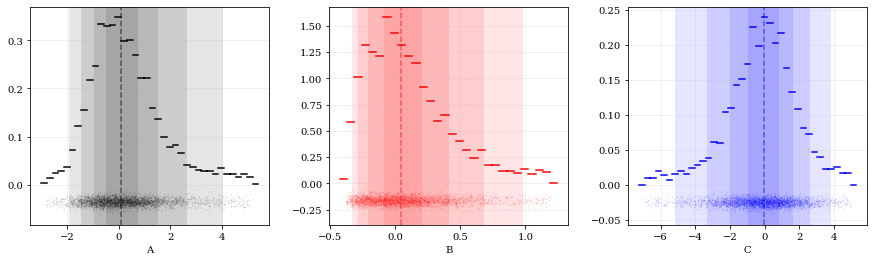

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-data-1d_04.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-data-1d_04.png'

In [10]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

for kk, ax in enumerate(axes):
    ax.grid(True, alpha=0.2)
    col = colors[kk]
    ax.set(xlabel=labels[kk])  
    kale.plot.dist1d_data(ax, data=data[kk], color=col)

nbshow()
fname = 'corner-test-data-1d.png'
save_fig(fig, fname)

## 2D Distributions

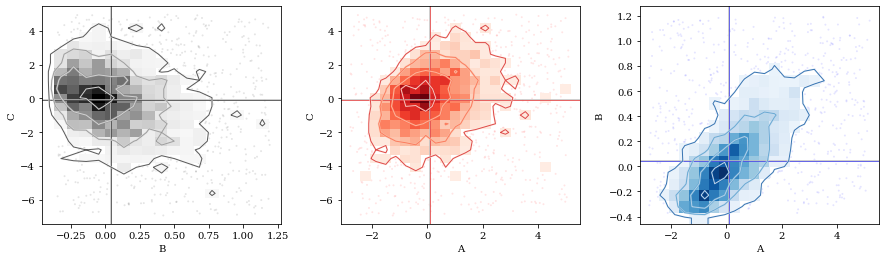

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-data-2d_03.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-data-2d_03.png'

In [11]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

for kk, ax in enumerate(axes):
    col = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    jj, ii = np.sort([jj, ii])
    td = [data[jj], data[ii]]
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    
    kale.plot.dist2d_data(ax, data=td, color=col,
                            mask_dense=True, mask_sparse=True, hist2d=True, density=True)

nbshow()
fname = 'corner-test-data-2d.png'
save_fig(fig, fname)

# KDEs

## Full Corner Plot

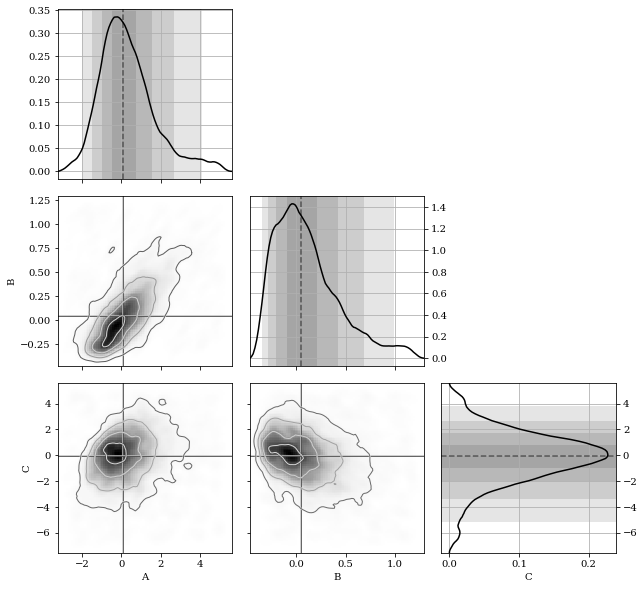

In [13]:
reload(kalepy.plot)
reload(kalepy.utils)

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)
corner = kale.plot.Corner(kde, figsize=[10, 10], labels=labels)
corner.plot_kde()

nbshow()

## 1D Distributions

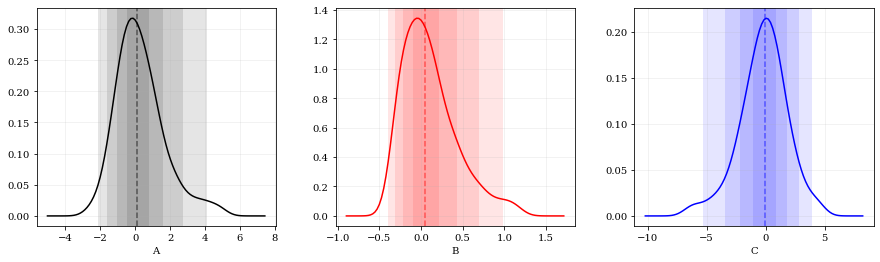

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-kde-1d_03.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-kde-1d_03.png'

In [14]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

kde = kale.KDE(data)

for kk, ax in enumerate(axes):
    ax.grid(True, alpha=0.2)
    col = colors[kk]
    ax.set(xlabel=labels[kk]) 
    kale.plot.dist1d_kde(ax, kde, param=kk, color=col)

nbshow()
fname = 'corner-test-kde-1d.png'
save_fig(fig, fname)

## 2D Distributions

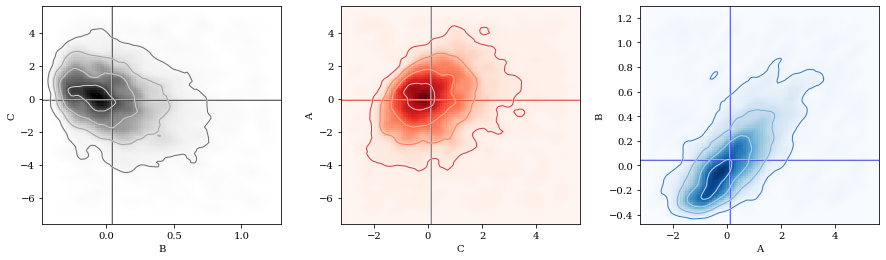

Saved to '/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-kde-2d_03.png'


'/Users/lzkelley/Programs/kalepy/notebooks/output/plotting/corner-test-kde-2d_03.png'

In [15]:
reload(kalepy.plot)
reload(kalepy.utils)

fig, axes = plt.subplots(figsize=[15, 4], ncols=3)
plt.subplots_adjust(wspace=0.25)
colors = ['k', 'r', 'b']

kernel = 'parabola'
# kernel = 'gaussian'
kde = kale.KDE(data, kernel=kernel)

for kk, ax in enumerate(axes):
    col = colors[kk]
    jj = (kk + 1) % 3
    ii = (kk + 2) % 3
    params = np.sort([jj, ii])
    ax.set(xlabel=labels[jj], ylabel=labels[ii])
    
    kale.plot.dist2d_kde(ax, kde, params=params, color=col)
    
nbshow()
fname = 'corner-test-kde-2d.png'
save_fig(fig, fname)